# T2 Shuffling implemented in SigPy

This is a demo of T2 Shuffling, implemented using SigPy.
Currently, it uses the "slow" version of the normal equations, because SigPy does not support directly
supplying the normal operator to the interative algorithms.

Gunzip the data in the `data` directory

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cupy as cp

import sigpy as sp
import sigpy.plot as pl


import time
import sys
import os.path

import cfl


%matplotlib notebook
import matplotlib.pyplot as plt


### for GPU, set `use_gpu = True`

In [2]:
use_gpu = True

In [3]:
if use_gpu:
    device = sp.Device(0)
else:
    device = sp.Device(-1)
print(device)

xp = device.xp

<CUDA Device 0>


In [4]:
def nrmse(x, y):
    return xp.linalg.norm(x - y) / xp.linalg.norm(x)

### Load data. It may need to be unzipped first

In [5]:
data_dir = 'data'

teksp = cfl.readcfl(os.path.join(data_dir, 'teksp')).squeeze()
cfksp = cfl.readcfl(os.path.join(data_dir, 'cfksp')).squeeze()
sens = np.expand_dims(cfl.readcfl(os.path.join(data_dir, 'sens')).squeeze(), axis=3)
pat = np.expand_dims(cfl.readcfl(os.path.join(data_dir, 'mask')).squeeze(), axis=2)
bas = cfl.readcfl(os.path.join(data_dir, 'bas')).squeeze()
cfimg = np.expand_dims(cfl.readcfl(os.path.join(data_dir, 'cfimg_recon')).squeeze(), axis=2)

print ('teksp:', teksp.shape)
print ('cfksp:', cfksp.shape)
print ('sens:', sens.shape)
print ('pat:', pat.shape)
print ('bas:', bas.shape)
print ('cfimg:', cfimg.shape)

ny, nz, nc, T = teksp.shape
K_full = cfimg.shape[3]

Phi = bas[:, :K_full].real

teksp: (260, 240, 7, 80)
cfksp: (260, 240, 7, 4)
sens: (260, 240, 7, 1)
pat: (260, 240, 1, 80)
bas: (80, 80)
cfimg: (260, 240, 1, 4)


### Compute space-time kernel. Currently not used in the actual recon due to limitations with SigPy interface

In [6]:
def stkern_mat(bas, mask):
    T, K = bas.shape
    ny, nz, _, nt = pat.shape
    assert(nt == T)
    z = pat.reshape((ny, nz, T, 1, 1)) * bas.reshape((1, 1, nt, 1, K))
    z2 = np.expand_dims(np.sum(z * bas.reshape((1, 1, T, K, 1)), axis=2), axis=2)
    return z2


print('Computing space time kernel')
tic = time.time()
stk = stkern_mat(Phi, pat)
toc = time.time()
print('Done: {}'.format(toc - tic))
print()

Computing space time kernel
Done: 0.8500027656555176



### Create SigPy linear operators

In [7]:

if device == sp.backend.cpu_device:    
    sens_ = sens
    Phi_ = Phi
    stk_ = stk
    pat_ = pat
    cfimg_ = cfimg
else:
    sens_ = sp.to_device(sens, device=device)
    Phi_ = sp.to_device(Phi, device=device)
    stk_ = sp.to_device(stk, device=device)
    pat_ = sp.to_device(pat, device=device)
    cfimg_ = sp.to_device(cfimg, device=device)

F_op = sp.linop.FFT([*cfksp.shape, 1], axes = (0, 1))
S_op = sp.linop.Multiply([*cfimg.shape, 1], sens_[...,None])
Psi_op = sp.linop.MatMul([*cfksp.shape, 1], stk_)
Phi_op = sp.linop.MatMul([*cfksp.shape, 1], Phi_[None, None, None, ...])
P_op = sp.linop.Multiply([*teksp.shape, 1], pat_[...,None])
T2sh_nrml_op = S_op.H * F_op.H * Psi_op * F_op * S_op
T2sh_op = P_op * Phi_op * F_op * S_op
print(T2sh_op.ishape, T2sh_op.oshape)

[260, 240, 1, 4, 1] [260, 240, 7, 80, 1]


### check fast vs slow normal equations operator

In [8]:
with device:
    print('Fast normal eq')
    tic = time.time()
    z1 = T2sh_nrml_op * cfimg_[..., None]
    toc = time.time()
    print('Done: {}'.format(toc - tic))
    print()

    print('Slow normal eq')
    tic = time.time()
    z2 = T2sh_op.H * T2sh_op * cfimg_[..., None]
    toc = time.time()
    print('Done: {}'.format(toc - tic))
    print()

    print('Error: {}'.format(nrmse(z1, z2)))

Fast normal eq
Done: 0.7492842674255371

Slow normal eq
Done: 0.0505826473236084

Error: 1.1775958e-07


### Create locally low rank soft threshold function and SigPy Prox operator

In [9]:
W = 10
S = 10
lamda = .04

def llr_soft_thresh(lam, block_op, W, S, input):

    input_reshape = input.reshape((input.shape[0], input.shape[1], -1))
    data = block_op * input_reshape
    data_reshape = data.reshape((data.shape[0], data.shape[1], -1, W*W))
    
    
    if device == sp.backend.cpu_device:    
        u, s, vh = np.linalg.svd(data_reshape, full_matrices=False)
        s_st = sp.soft_thresh(lam, s)
        data_reshape_st = u * s_st[..., None, :] @ vh
    else:
        data_reshape_st = 0 * data_reshape
        # cupy does not support block SVD. loop over outer dims
        for ii in range(data.shape[0]):
            for jj in range(data.shape[1]):
                uu, ss, vvh = cp.linalg.svd(data_reshape[ii, jj, ...], full_matrices=False)
                ss_st = sp.soft_thresh(lam, ss)
                data_reshape_st[ii, jj, ...] = uu * ss_st @ vvh
    
    output = block_op.H * data_reshape_st.reshape(data.shape)
    return output.reshape((input.shape))

class LLRProx(sp.prox.Prox):
    def __init__(self, shape, lamda, W, S, rand_shift=True):
        self.W = W
        self.S = S
        self.lamda = lamda
        self.rand_shift = rand_shift
        self.block_op = sp.linop.ArrayToBlocks([shape[0], shape[1], shape[3]], [W, W, 1], [S, S, 1])
        super().__init__(shape)
        
    def _prox(self, alpha, input):
        if self.rand_shift:
            shift_x, shift_y = np.random.randint(0, self.W, size=2)
            shift_shape = [shift_x, shift_y]
            C_op = sp.linop.Circshift(self.shape, shift_shape, axes=[0, 1])
            input = C_op * input

        output = llr_soft_thresh(self.lamda * alpha, self.block_op, self.W, self.S, input)

        if self.rand_shift:
            output = C_op.H * output
            
        return output
    
proxg = LLRProx(T2sh_op.ishape, lamda, W, S)
# proxg = LLRProx(T2sh_op.ishape, lamda, W, S, rand_shift=False)

### Scale data similar to BART

In [10]:
teksp_center = sp.resize(teksp, [32, 32, *teksp.shape[2:]])
cfimg_center = np.linalg.norm(np.linalg.norm(sp.ifft(teksp_center, axes=[0, 1]), axis=-1), axis=-1)
scale = np.percentile(abs(cfimg_center.ravel()), 95)


### Build app and run recon

In [11]:
max_iter = 250
alpha = .95

teksp_scale = teksp / scale

if device == sp.backend.cpu_device:    
    teksp_scale_ = teksp_scale
else:
    teksp_scale_ = sp.to_device(teksp_scale, device=device)
    


with device:
    T2sh_app = sp.app.LinearLeastSquares(T2sh_op,
                                     teksp_scale_[...,None],
                                     proxg=proxg,
                                     alg_name='GradientMethod',
                                     alpha=alpha,
                                     max_iter=max_iter,
                                     accelerate=True)

    cfimg_recon_ = T2sh_app.run() * scale


LinearLeastSquares: 100%|██████████| 250/250 [01:43<00:00,  2.45it/s, resid=1.04E+00]


<IPython.core.display.Javascript object>


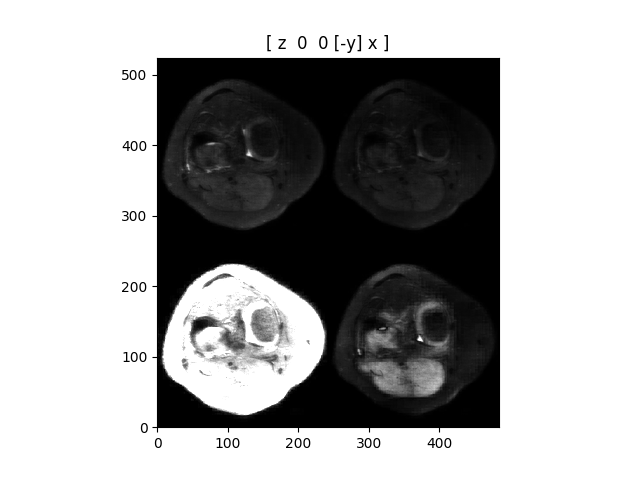

In [12]:
cfimg_recon = sp.to_device(cfimg_recon_)
pl.ImagePlot(cfimg_recon.transpose((3, 2, 4, 0, 1)))


In [13]:
teimg_recon = sp.linop.MatMul(cfimg_recon_.shape, Phi[None, None, None, ...])(cfimg_recon_)

<IPython.core.display.Javascript object>


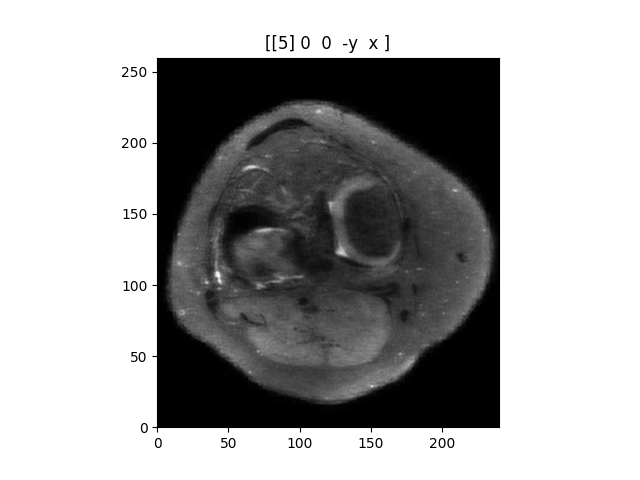

In [14]:
pl.ImagePlot(teimg_recon.transpose((3, 2, 4, 0, 1)))